In [39]:
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#matplotlib.use('tkagg')
%matplotlib inline

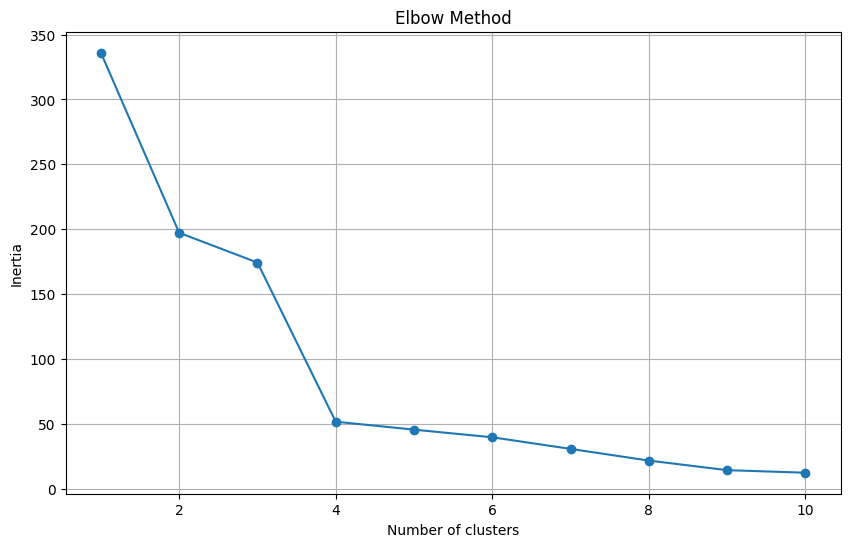

In [40]:
#
# Пример данных
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath("cluster_analysis.ipynb")))
data = pd.read_excel(f'{parent_dir}/../data/fundamentals_shares.xlsx')

    # Создание DataFrame
df = pd.DataFrame(data)

    # Удаление строк с NaN
df.dropna(subset=['P/B', 'ROE'], inplace=True)

    # Выбор признаков для кластеризации
features = df[['P/B', 'ROE']]
    # Стандартизация данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

    #Метод локтя для определения оптимального числа кластеров
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid()
plt.show()    

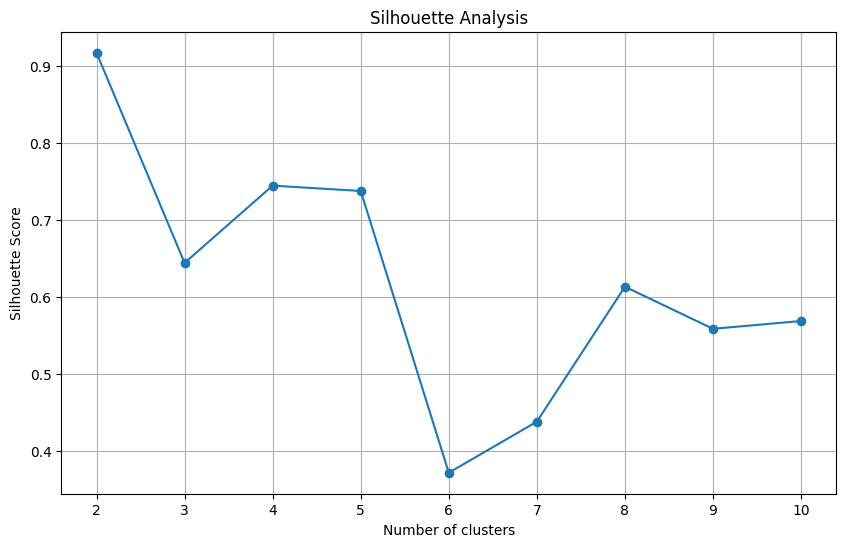

In [ ]:
# Метод анализа силуэтов для выбора кол-ва кластеров
from sklearn.metrics import silhouette_score

silhouette_scores = []
cluster_count = 0
max_silhouette_score = 0
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
        
    if max_silhouette_score < silhouette_avg:
        max_silhouette_score = silhouette_avg
        cluster_count = k

cluster_count = 4
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid()
plt.show()

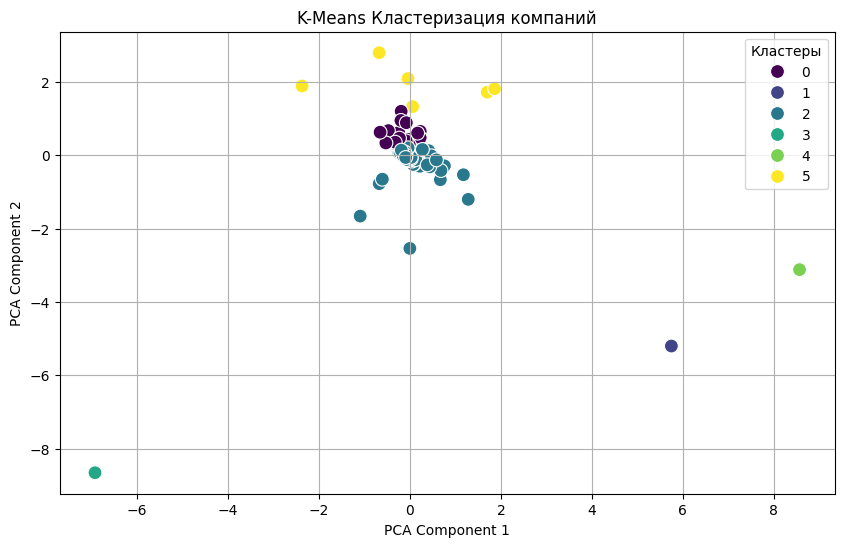

In [42]:
# Определение количества кластеров
kmeans = KMeans(n_clusters=cluster_count, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Визуализация кластеров с помощью PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100)
plt.title('K-Means Кластеризация компаний')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Кластеры')
plt.grid()
plt.show()

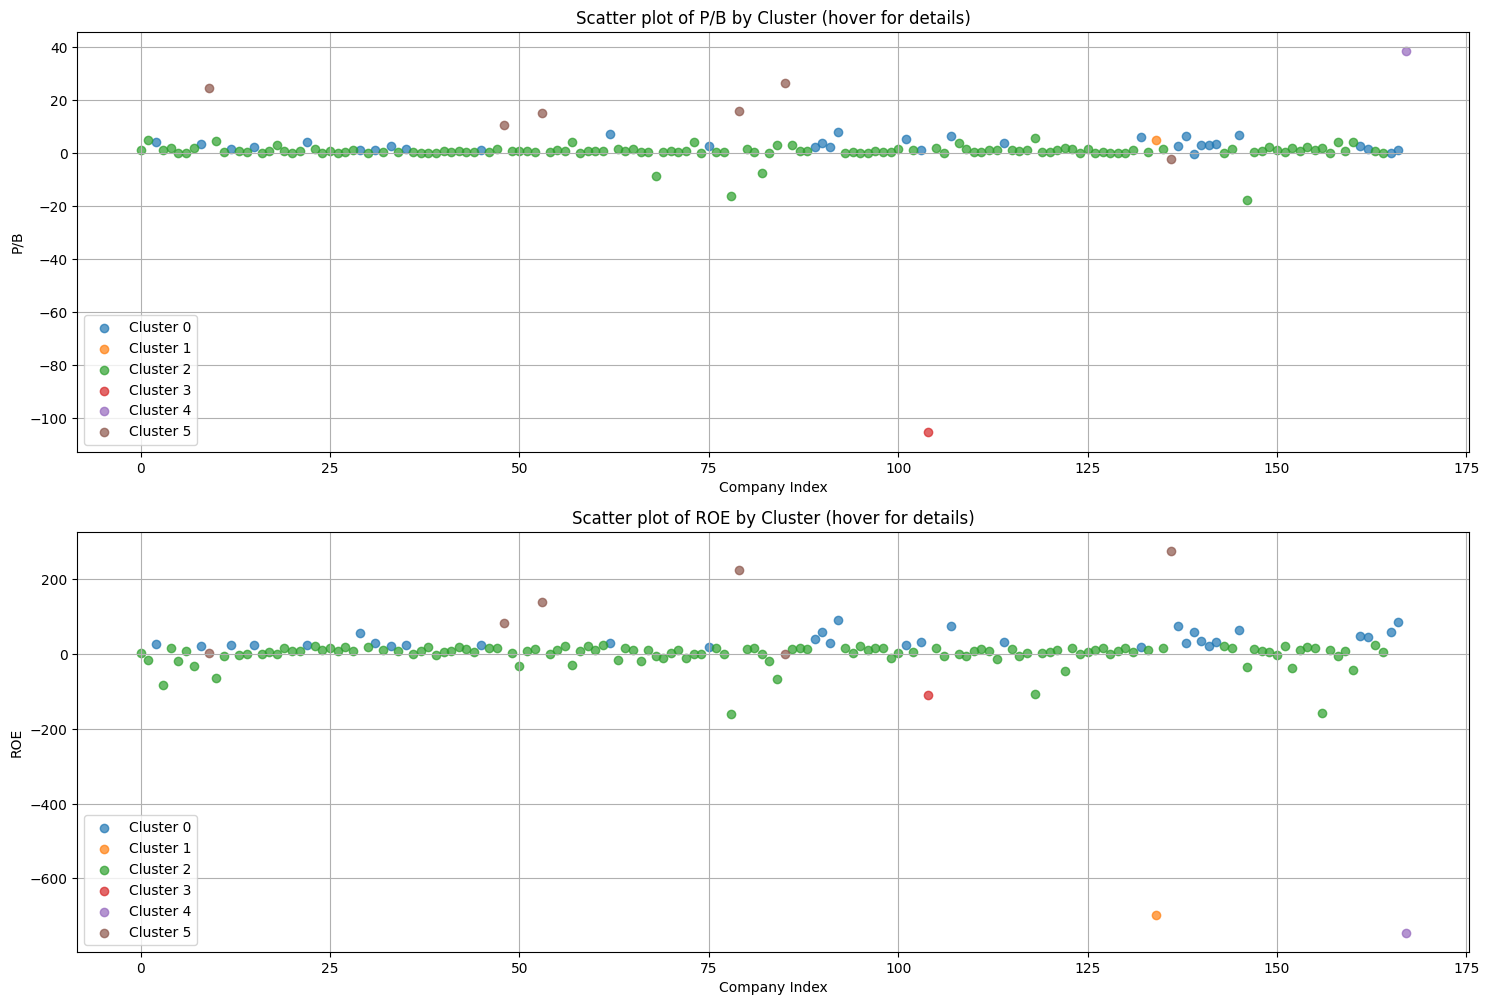

In [43]:
# Детали кластеризации
import mplcursors
n_features = len(features)
plt.figure(figsize=(15, 5*n_features))

for i, feature in enumerate(features):
    plt.subplot(n_features, 1, i+1)
        
    # Создаем scatter plot для каждого кластера
    for cluster in range(cluster_count):
        cluster_data = df[df['Cluster'] == cluster]
        scatter = plt.scatter(cluster_data.index, cluster_data[feature], 
                                label=f'Cluster {cluster}', alpha=0.7)
            
        # Добавляем интерактивные подписи
        cursor = mplcursors.cursor(scatter, hover=True)
        cursor.connect(
                "add", 
                lambda sel: sel.annotation.set_text(
                    f"Company: {df['Company'].iloc[sel.target.index]}\n"
                    f"Cluster: {df['Cluster'].iloc[sel.target.index]}\n"
                    f"{feature}: {sel.target[1]:.2f}"
                )
            )
        
    plt.title(f'Scatter plot of {feature} by Cluster (hover for details)')
    plt.xlabel('Company Index')
    plt.ylabel(feature)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

c:\Users\nikit\InvestProject\AnaliticSystem\.venv\Lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
c:\Users\nikit\InvestProject\AnaliticSystem\.venv\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)
c:\Users\nikit\InvestProject\AnaliticSystem\.venv\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=vector, **plot_kwargs)


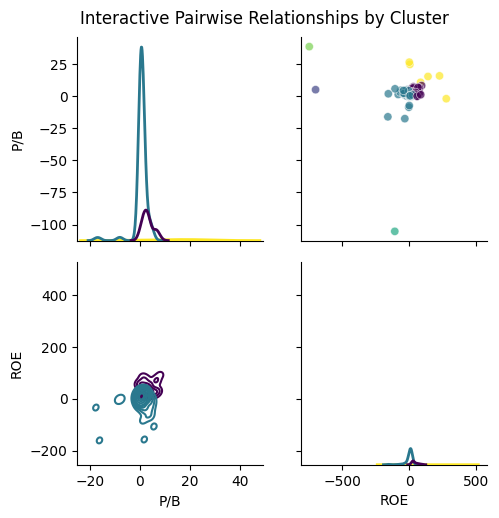

C:\Users\nikit\AppData\Local\Temp\ipykernel_17396\3029207235.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis')
C:\Users\nikit\AppData\Local\Temp\ipykernel_17396\3029207235.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis')


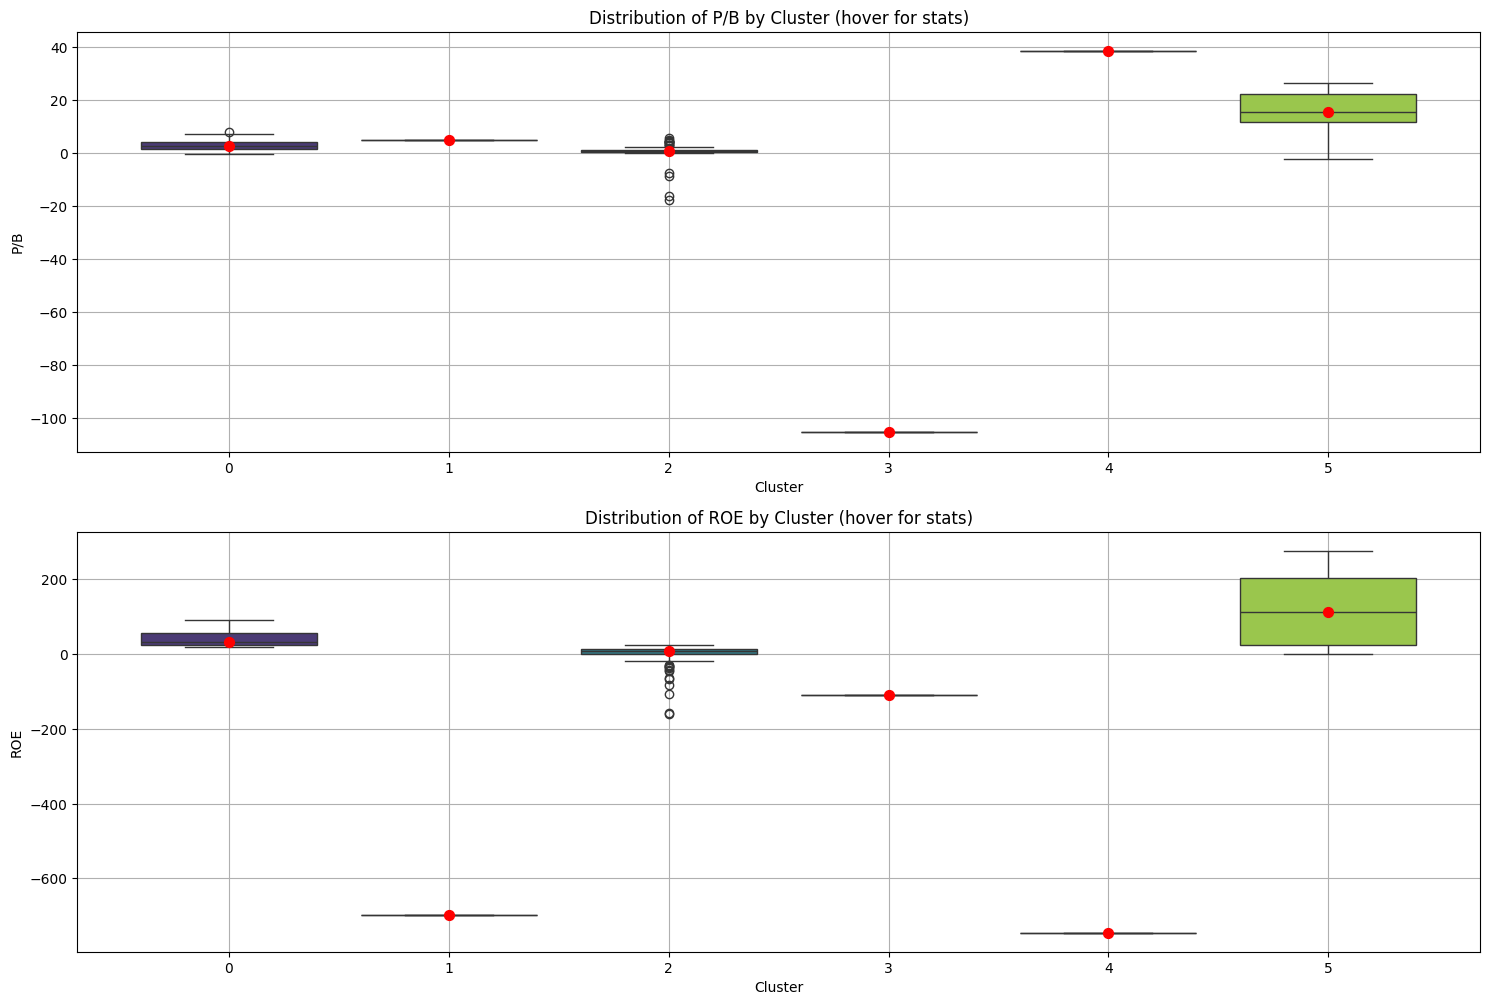

In [44]:
# Парные диаграммы рассеяния с выделением кластеров
# Создаем PairGrid вручную для добавления mplcursors
g = sns.PairGrid(df, vars=features, hue='Cluster', palette='viridis')
g.map_upper(sns.scatterplot, alpha=0.7)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

# Добавляем интерактивные подписи ко всем scatter plot
for ax in g.axes.flat:
    if ax is not None:
         for collection in ax.collections:
            if isinstance(collection, matplotlib.collections.PathCollection):  # Это scatter точки
                cursor = mplcursors.cursor(collection, hover=True)
                cursor.connect(
                        "add", 
                        lambda sel: sel.annotation.set_text(
                            f"Company: {df['Company'].iloc[sel.target.index]}\n"
                            f"Cluster: {df['Cluster'].iloc[sel.target.index]}\n"
                            f"X: {sel.target[0]:.2f}\nY: {sel.target[1]:.2f}"
                        )
                    )

plt.suptitle('Interactive Pairwise Relationships by Cluster', y=1.02)
plt.show()

# Боксплоты для анализа распределения признаков в кластерах
plt.figure(figsize=(15, 5*n_features))

for i, feature in enumerate(features):
    plt.subplot(n_features, 1, i+1)
        
    # Создаем boxplot
    boxplot = sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis')
        
    # Добавляем интерактивные подписи для средних значений
    for cluster in range(cluster_count):
        cluster_data = df[df['Cluster'] == cluster][feature]
        median = cluster_data.median()
        mean = cluster_data.mean()
            
        # Добавляем точку с медианой
        scatter = plt.scatter([cluster], [median], color='red', s=50, zorder=5)
            
        cursor = mplcursors.cursor(scatter, hover=True)
        cursor.connect(
                "add", 
                lambda sel, c=cluster, m=median, mn=mean: sel.annotation.set_text(
                    f"Cluster {c}\n"
                    f"Median: {m:.2f}\n"
                    f"Mean: {mn:.2f}\n"
                    f"Count: {len(df[df['Cluster'] == c])}"
                )
            )
        
    plt.title(f'Distribution of {feature} by Cluster (hover for stats)')
    plt.grid()

plt.tight_layout()
plt.show()

Результаты кластеризации сохранены в файл 'clustered_companies_p_bv6.xlsx'


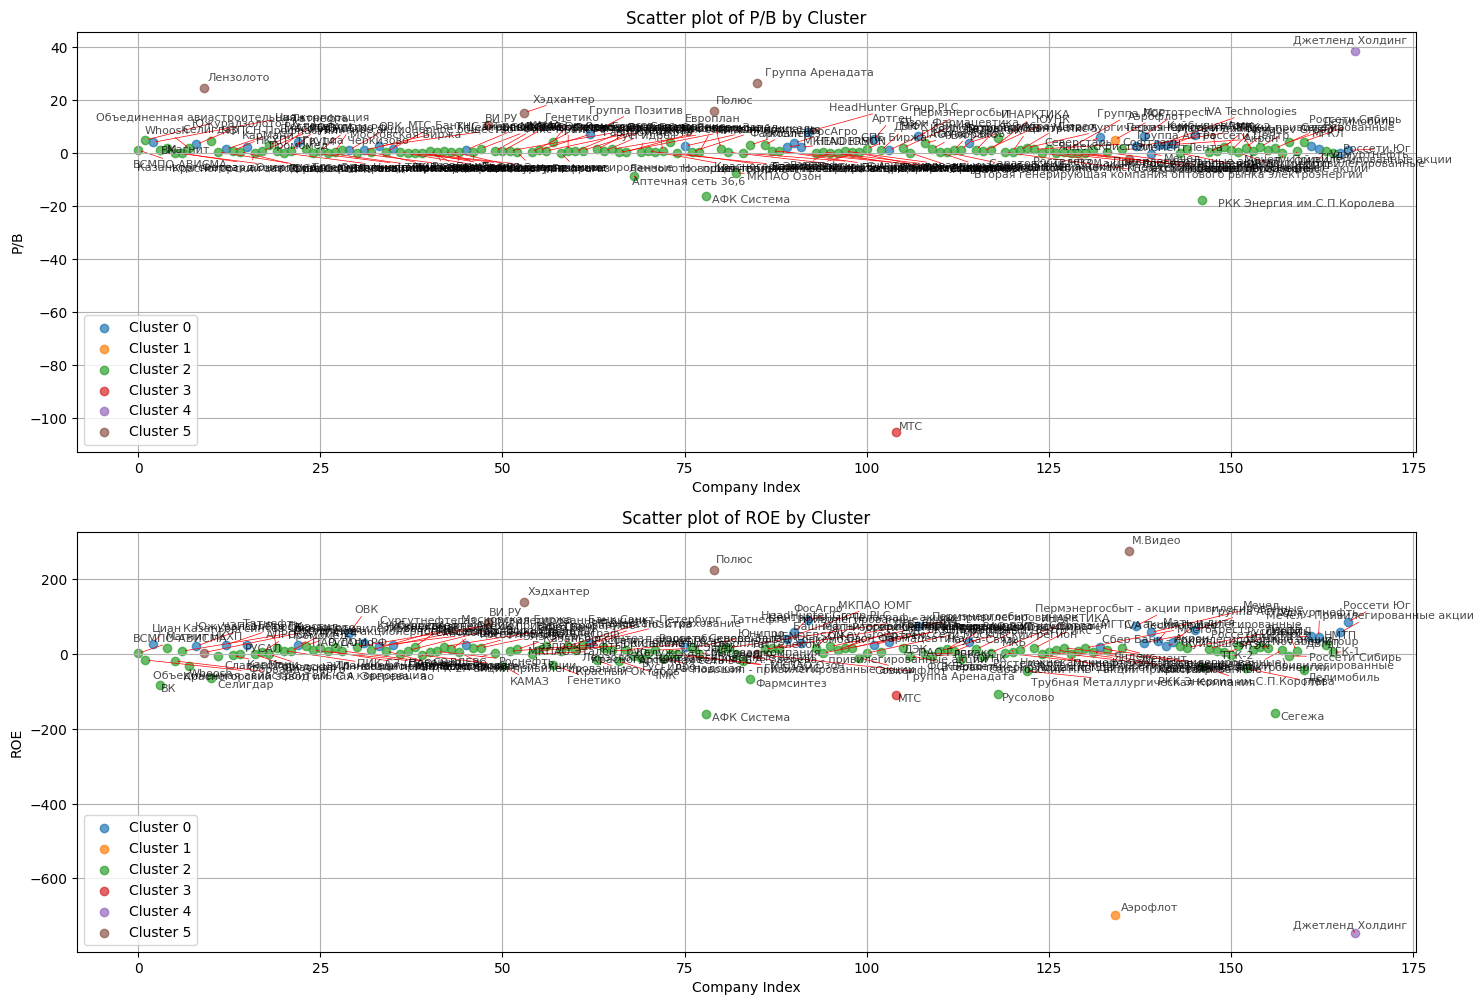

C:\Users\nikit\AppData\Local\Temp\ipykernel_17396\238217991.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis')
C:\Users\nikit\AppData\Local\Temp\ipykernel_17396\238217991.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis')


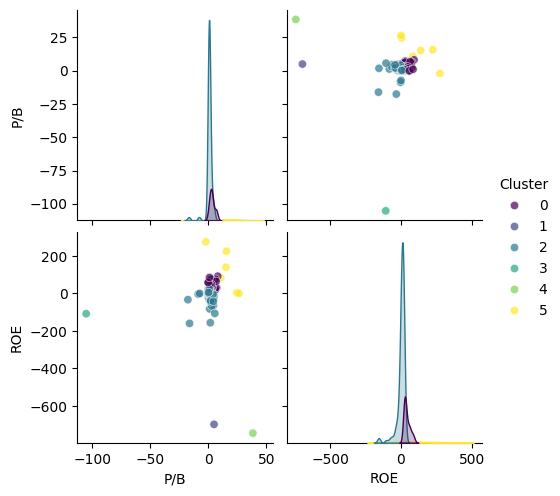

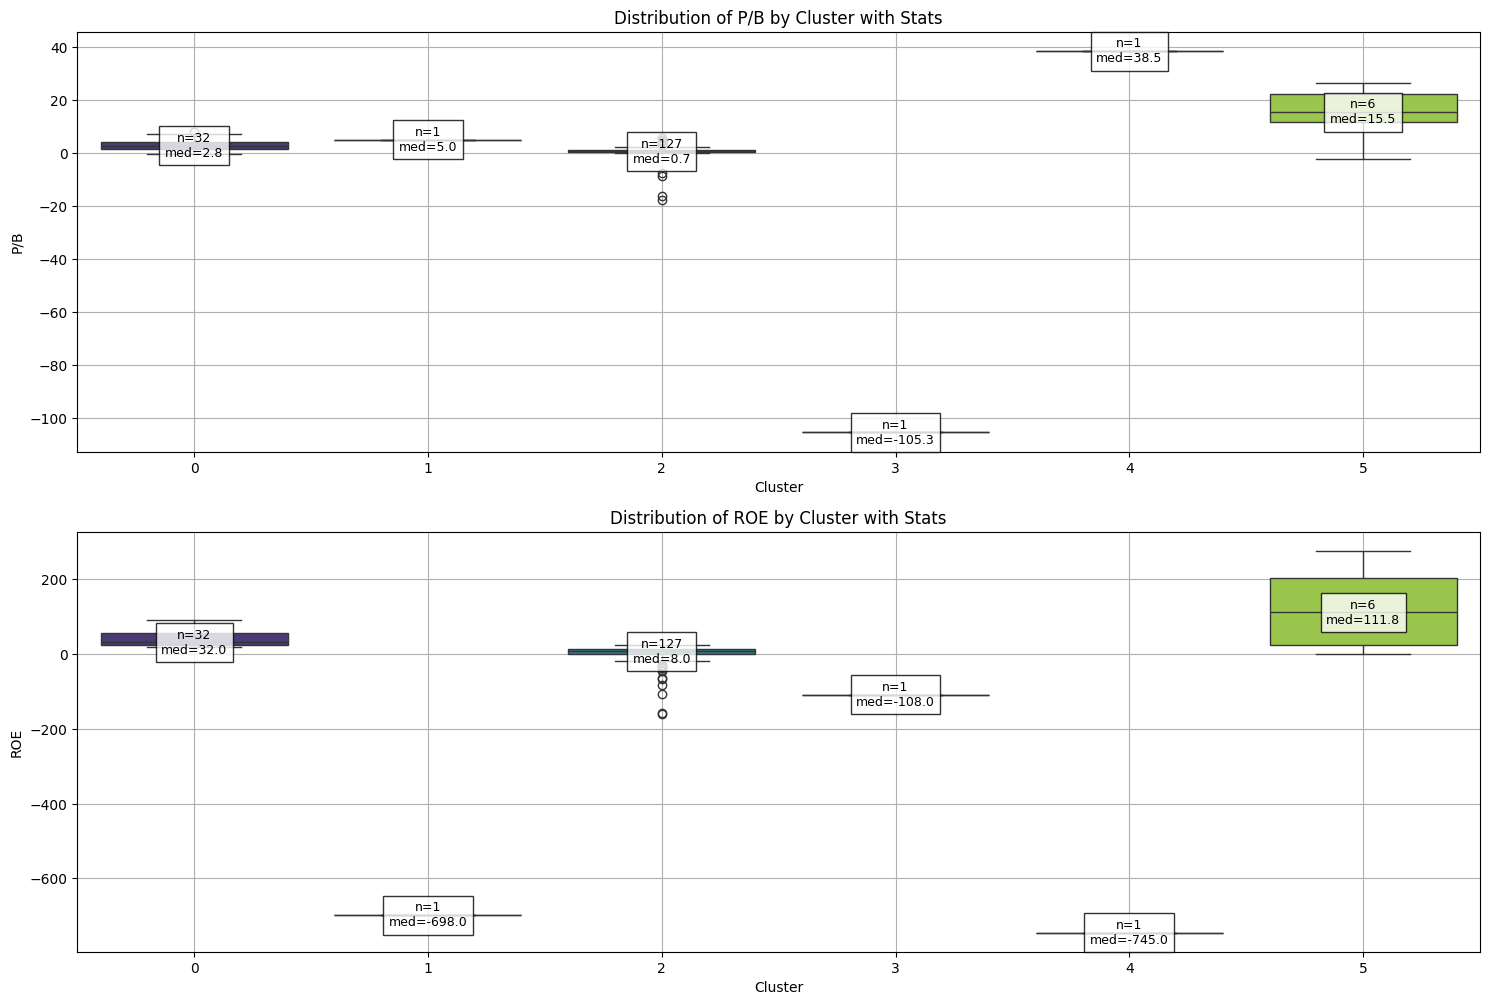

In [45]:
# Сохранение результатов в Excel
output_file = f'clustered_companies_p_bv{cluster_count}.xlsx'
df.to_excel(output_file, index=False)

print(f"Результаты кластеризации сохранены в файл '{output_file}'")

# Детали кластеризации с подписью данных
from adjustText import adjust_text

n_features = len(features)
plt.figure(figsize=(15, 5*n_features))

for i, feature in enumerate(features):
    plt.subplot(n_features, 1, i+1)
        
    # Создаем scatter plot для каждого кластера
    for cluster in range(cluster_count):
        cluster_data = df[df['Cluster'] == cluster]
        plt.scatter(cluster_data.index, cluster_data[feature], 
                    label=f'Cluster {cluster}', alpha=0.7)
        
        # Добавляем подписи с автоматической регулировкой
    texts = []
    for idx, row in df.iterrows():
        texts.append(plt.text(row.name, row[feature], row['Название'], 
                                fontsize=8, alpha=0.7))
        
        # Автоматическое регулирование положения подписей
    adjust_text(texts, 
                only_move={'points':'y', 'texts':'y'}, 
                arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
        
    plt.title(f'Scatter plot of {feature} by Cluster')
    plt.xlabel('Company Index')
    plt.ylabel(feature)
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

# визуализация кластеров
g = sns.pairplot(df, vars=features, hue='Cluster', 
                palette='viridis', plot_kws={'alpha': 0.7}, 
                diag_kind='kde')

    # средние характеристики по кластерам
plt.figure(figsize=(15, 5*n_features))

for i, feature in enumerate(features):
    plt.subplot(n_features, 1, i+1)
        
    # Создаем boxplot
    sns.boxplot(x='Cluster', y=feature, data=df, palette='viridis')
        
    # Добавляем аннотации с ключевыми статистиками
    for cluster in range(cluster_count):
        cluster_data = df[df['Cluster'] == cluster][feature]
        median = cluster_data.median()
        count = len(cluster_data)
            
        plt.text(cluster, median, f"n={count}\nmed={median:.1f}", 
                    ha='center', va='center', fontsize=9,
                    bbox=dict(facecolor='white', alpha=0.8))
        
    plt.title(f'Distribution of {feature} by Cluster with Stats')
    plt.grid()

plt.tight_layout()
plt.show()